<a href="https://colab.research.google.com/github/mdeniz1/datascienceprojects/blob/main/Sales_Forecasting_XGBoost_vs_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

My project centers on predicting global sales for a cosmetics company product, employing a time series analysis approach with Python. I initially explore data characteristics using statistical measures and visualizations. Despite encountering extreme values, I abstain from outlier removal due to potential data loss and the robustness of selected models: XGBoost and LSTM. I address low-variability features by eliminating those with a standard deviation under 0.5. Employing XGBoost, I achieve a well-tuned model using RandomizedSearchCV, yielding promising test results and a Root Mean Squared Error (RMSE) of 27 and 3% mean absolute percentage error.  Additionally, I implement an LSTM-based neural network which performs slightly worse with a 10% average percentage error, favoring XGBoost's 3% error for better sales predictions.





In [ ]:
!pip install statsmodels


In [ ]:
!pip install xgboost


In [ ]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import xgboost as xgb
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import backend as K




In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = r'/content/drive/My Drive/Data Science Case Study - Senior/final_data.xlsx'
df1 = pd.read_excel(path)

In [ ]:
df=df1.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  50000 non-null  int64 
 1   AUS_1       50000 non-null  int64 
 2   AUS_2       50000 non-null  int64 
 3   AUS_3       50000 non-null  int64 
 4   CAN_1       50000 non-null  int64 
 5   CAN_2       50000 non-null  int64 
 6   CAN_3       50000 non-null  int64 
 7   GER_1       50000 non-null  int64 
 8   GER_2       50000 non-null  int64 
 9   GER_3       50000 non-null  int64 
 10  FRA_1       50000 non-null  int64 
 11  FRA_2       50000 non-null  int64 
 12  FRA_3       50000 non-null  int64 
 13  IND_1       50000 non-null  int64 
 14  IND_2       50000 non-null  int64 
 15  IND_3       50000 non-null  int64 
 16  JAP_1       50000 non-null  int64 
 17  JAP_2       50000 non-null  int64 
 18  JAP_3       50000 non-null  int64 
 19  USA_1       50000 non-null  int64 
 20  USA_2 

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('factor', axis=1, inplace=True)


Below plot shows the distibution of Sales values in the data set.

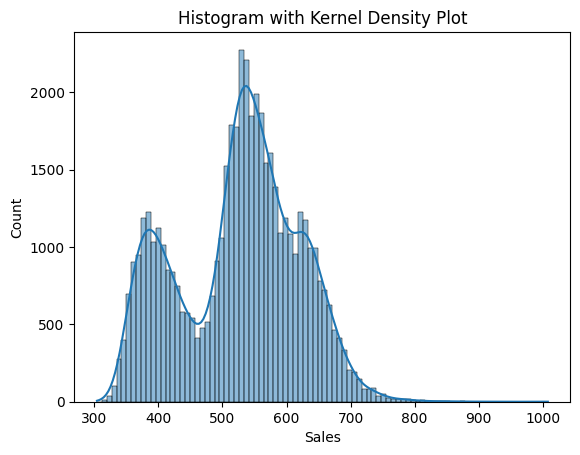

In [ ]:

sns.histplot(df['Sales'], kde=True)
plt.title('Histogram with Kernel Density Plot')
plt.show()




while mean and median are close to each other, the distribution of sales column is bimodal instead of a normal distribution.

In [ ]:
df.describe()

,AUS_1,AUS_2,AUS_3,CAN_1,CAN_2,CAN_3,GER_1,GER_2,GER_3,FRA_1,FRA_2,FRA_3,IND_1,IND_2,IND_3,JAP_1,JAP_2,JAP_3,USA_1,USA_2,USA_3,UK_1,UK_2,UK_3,Sales
count,50000.000000,50000.000000,50000.0,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.997260,1.991660,3.0,4.000000,4.995660,5.998960,7.04050,7.98978,8.999180,9.961420,11.042120,11.995140,13.001580,14.000900,14.992060,15.991120,17.0,18.000500,18.998540,19.996120,20.996540,21.997240,22.999840,23.999980,524.931240
std,0.303009,2.067771,0.0,0.021909,1.813479,0.860589,7.04064,1.77842,1.136312,9.918767,10.972653,1.238478,0.658108,0.124175,15.017374,1.846356,0.0,1.651434,0.903877,0.854447,0.314213,1.119258,0.803675,0.022361,94.391597
min,0.000000,0.000000,3.0,3.000000,-3.000000,3.000000,0.00000,0.00000,4.000000,0.000000,0.000000,7.000000,10.000000,13.000000,0.000000,9.000000,17.0,11.000000,15.000000,17.000000,20.000000,17.000000,19.000000,23.000000,304.000000
25%,1.000000,1.000000,3.0,4.000000,4.000000,5.000000,2.00000,7.00000,8.000000,3.000000,3.000000,11.000000,13.000000,14.000000,4.000000,15.000000,17.0,17.000000,18.000000,19.000000,21.000000,21.000000,22.000000,24.000000,449.000000
50%,1.000000,1.000000,3.0,4.000000,5.000000,6.000000,5.00000,8.00000,9.000000,7.000000,8.000000,12.000000,13.000000,14.000000,10.000000,16.000000,17.0,18.000000,19.000000,20.000000,21.000000,22.000000,23.000000,24.000000,535.000000
75%,1.000000,3.000000,3.0,4.000000,6.000000,7.000000,10.00000,9.00000,10.000000,14.000000,15.000000,13.000000,13.000000,14.000000,21.000000,17.000000,17.0,19.000000,20.000000,21.000000,21.000000,23.000000,24.000000,24.000000,591.000000
max,2.000000,24.000000,3.0,5.000000,12.000000,10.000000,83.00000,15.00000,13.000000,121.000000,125.000000,17.000000,16.000000,15.000000,185.000000,24.000000,17.0,25.000000,22.000000,23.000000,22.000000,26.000000,26.000000,25.000000,1008.000000


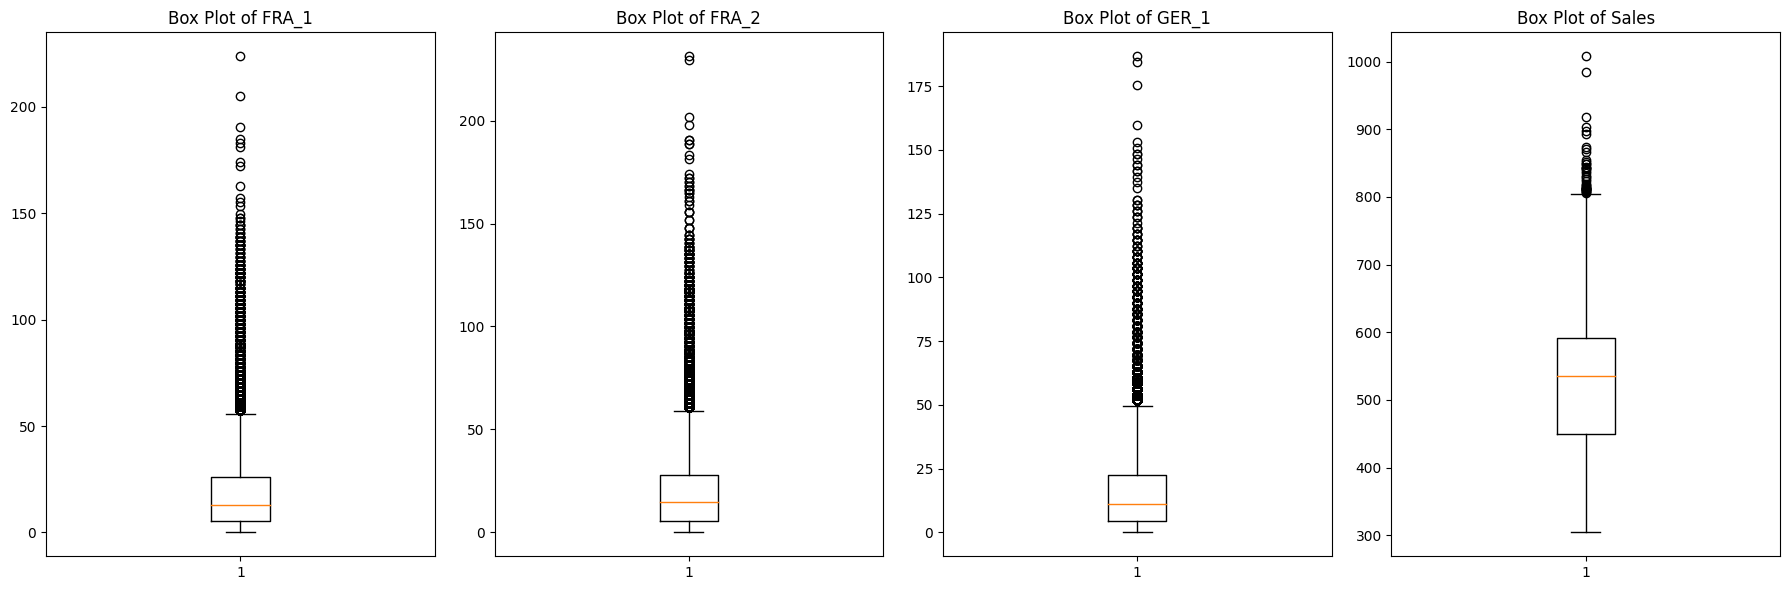

In [ ]:


fig, axes = plt.subplots(1, 4, figsize=(18, 6))

axes[0].boxplot(df['FRA_1'])
axes[0].set_title('Box Plot of FRA_1')

axes[1].boxplot(df['FRA_2'])
axes[1].set_title('Box Plot of FRA_2')

axes[2].boxplot(df['GER_1'])
axes[2].set_title('Box Plot of GER_1')

axes[3].boxplot(df['Sales'])
axes[3].set_title('Box Plot of Sales')

plt.tight_layout()
plt.show()





As you can see in summary statistics and the box plots of a few input column above, some of the columns have extreme values.I considered whether to apply outlier detection and removal.
I decided not to delete outliers because of **three reasons**.

1) I tried Tuckey's method, isolation forest and rebust z score for outlier detection and removal and ended up with half the size of the original dataframe. This led me think that I might be losing some important information in the first place.

2)I have scant knowledge on the domain and I am not sure whether the outliers in the data are geniune values or noise-errors in forming the data set. As the task document suggest, they might well be due to seasonal hikes in demands and sales.

3) Last but not the least, I apply two machine learning models which are known to be rebust to outliers: Xgboost and ANN with LSTM layer.

**That is why**, I decided not to apply any outlier removaL process.

I have noticed that some features lack variability, as their standard deviation is either 0 or very close to zero. Such features do not provide meaningful information for modeling, as they essentially remain constant throughout the dataset. To improve the model's performance and reduce unnecessary complexity, I have chosen to remove columns with a standard deviation lower than 0.5. By doing so, we eliminate features that do not contribute to the predictive power of the model, leading to a more efficient analysis.





In [ ]:
std_per_column = df.std(numeric_only=True)

columns_to_drop = std_per_column[std_per_column <= 0.5].index

df.drop(columns_to_drop, axis=1, inplace=True)


In [ ]:
# deleting negative values in CAN_2 column
df = df[df['CAN_2'] >= 0]


In [ ]:
std_per_column = df.std()

columns_to_check = std_per_column[std_per_column <= 1.1].index

df_check=df[columns_to_check]
for column in df_check.columns:
  value_counts = df_check[column].value_counts()
  print("Value counts:\n", value_counts)


Value counts:
 6     22989
5     11962
7     11860
8      1554
4      1546
9        49
3        39
10        1
Name: CAN_3, dtype: int64
Value counts:
 13    30106
14     9690
12     9622
15      293
11      286
10        2
16        1
Name: IND_1, dtype: int64
Value counts:
 19    21897
20    12098
18    12032
17     1945
21     1864
22       86
16       77
15        1
Name: USA_1, dtype: int64
Value counts:
 20    23154
19    11961
21    11804
18     1503
22     1495
17       45
23       38
Name: USA_2, dtype: int64
Value counts:
 23    24743
22    11645
24    11327
25     1199
21     1051
26       20
20       14
19        1
Name: UK_2, dtype: int64


Now, we have 16 featueres and one output column.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   AUS_2   50000 non-null  int64
 1   CAN_2   50000 non-null  int64
 2   CAN_3   50000 non-null  int64
 3   GER_1   50000 non-null  int64
 4   GER_2   50000 non-null  int64
 5   GER_3   50000 non-null  int64
 6   FRA_1   50000 non-null  int64
 7   FRA_2   50000 non-null  int64
 8   FRA_3   50000 non-null  int64
 9   IND_1   50000 non-null  int64
 10  IND_3   50000 non-null  int64
 11  JAP_1   50000 non-null  int64
 12  JAP_3   50000 non-null  int64
 13  USA_1   50000 non-null  int64
 14  USA_2   50000 non-null  int64
 15  UK_1    50000 non-null  int64
 16  UK_2    50000 non-null  int64
 17  Sales   50000 non-null  int64
dtypes: int64(18)
memory usage: 6.9 MB


## **feature engineering**

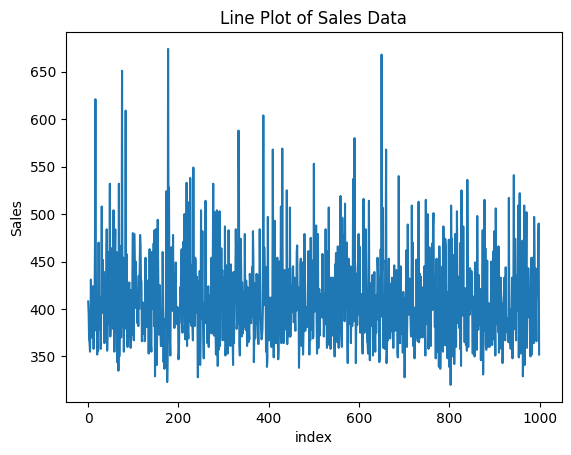

In [ ]:

#For better visibility, I am displaying only the first 1000 values of the dataset

plt.plot(df['Sales'].iloc[:1000])

plt.xlabel('index')
plt.ylabel('Sales')
plt.title('Line Plot of Sales Data')
plt.show()


While there seems to be seasonality in the sales column, the exact pattern is not definite. To address this, I plan to use lag features for both the output and the input by observing auto-correlation.

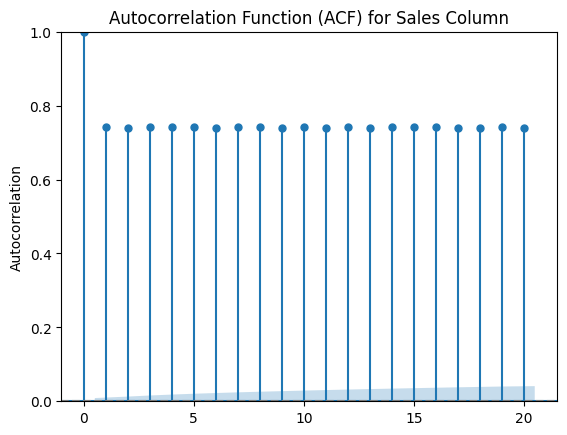

In [ ]:
fig, ax = plt.subplots()
plot_acf(df['Sales'], lags=20, ax=ax)
ymin, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

ax.axhline(y=0, color='gray', linestyle='--')
plt.ylabel('Autocorrelation')
plt.title(f'Autocorrelation Function (ACF) for Sales Column')
plt.show()

The autocorrelation is consistently high for all the lags, starting at 0.75 for the initial lags and gradually decreasing. Considering this, I will use lag 1 and lag 2 initially to avoid potential overfitting of the model on the data. If necessary, I can increase the number of lags later on.

I have also checked the autocorrelation for the feature variables, and since there are 17 of them, displaying all of them might be overwhelming.

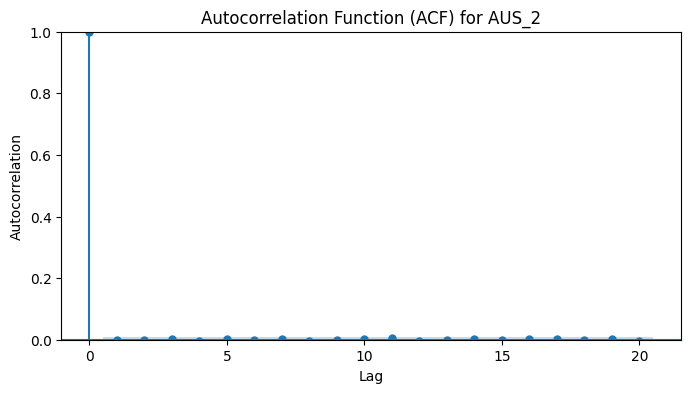

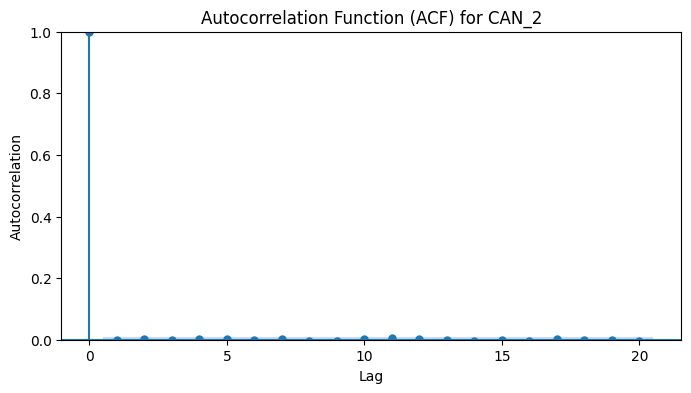

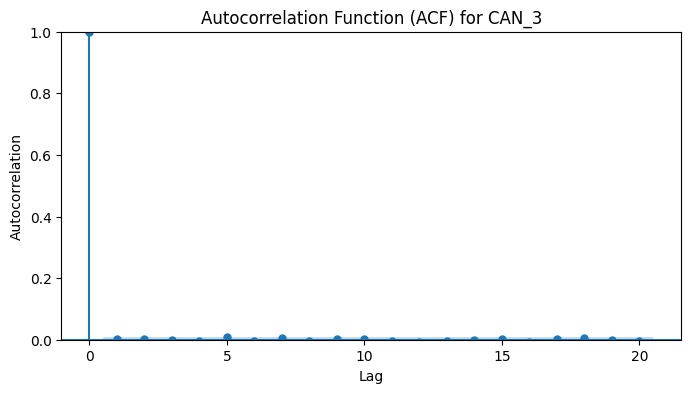

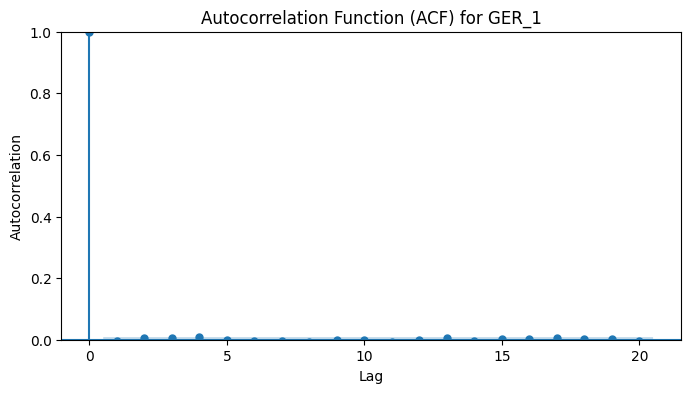

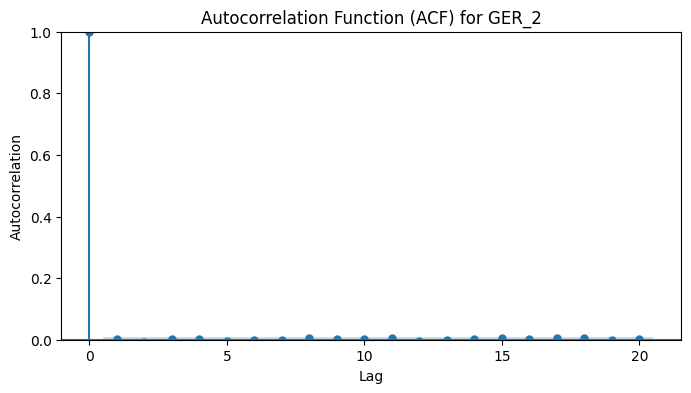

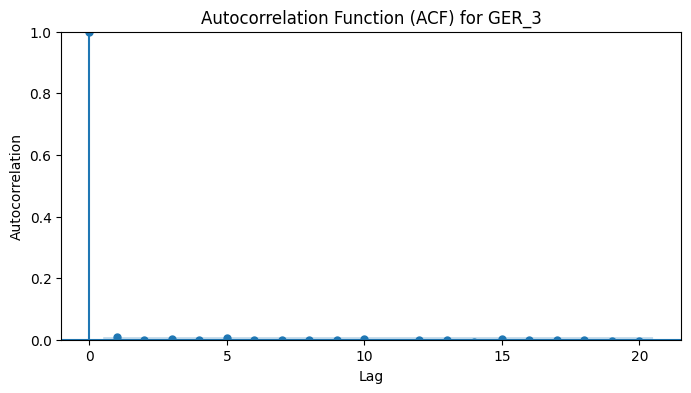

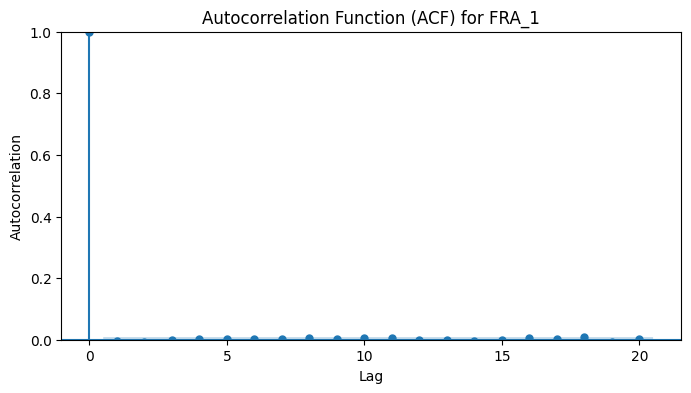

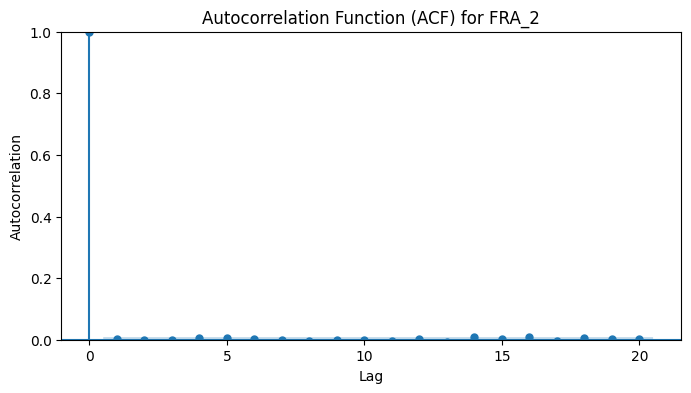

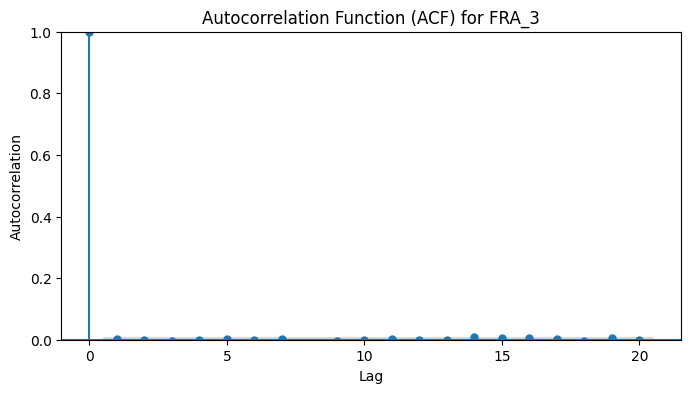

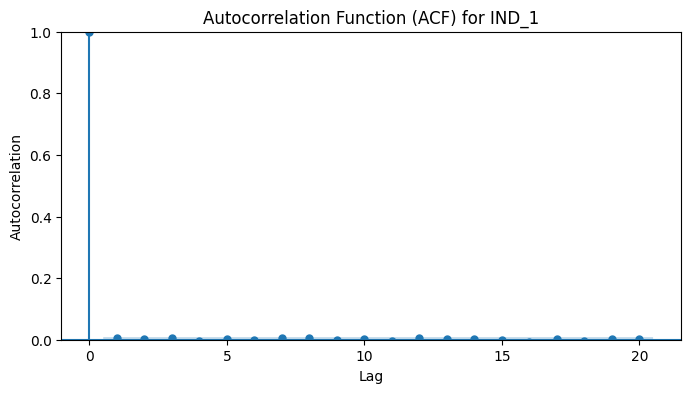

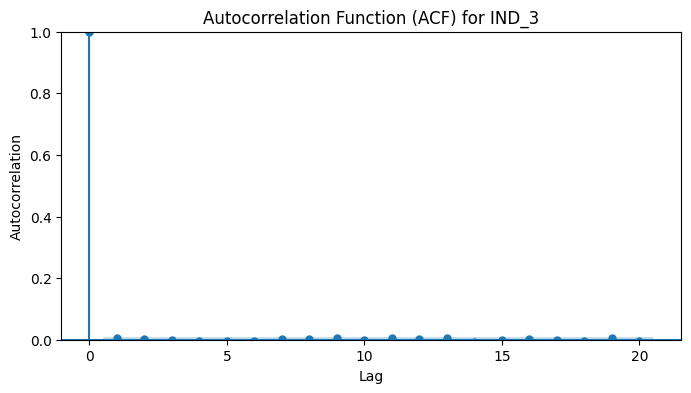

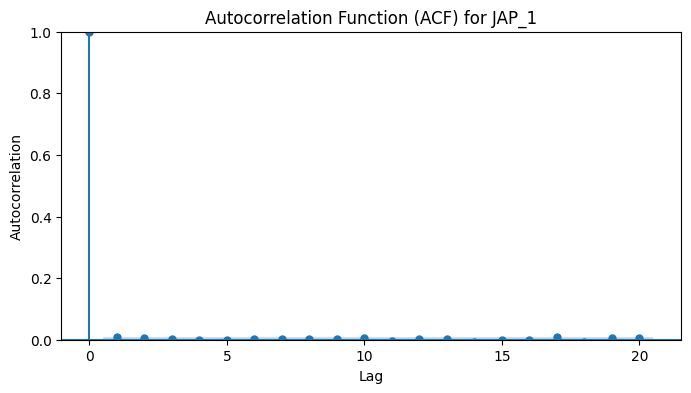

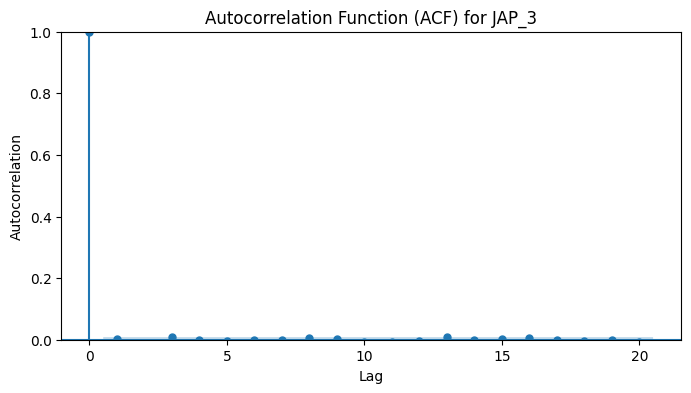

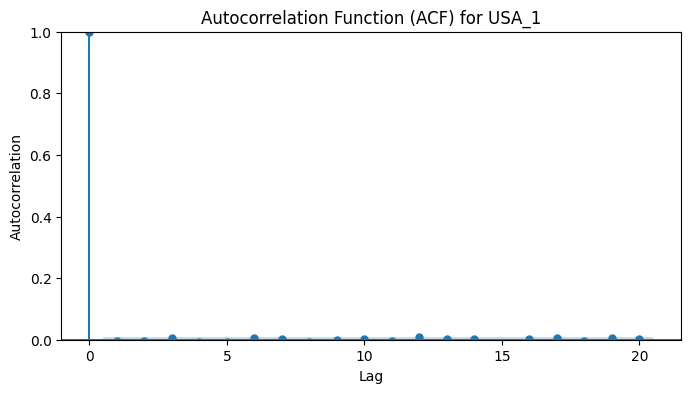

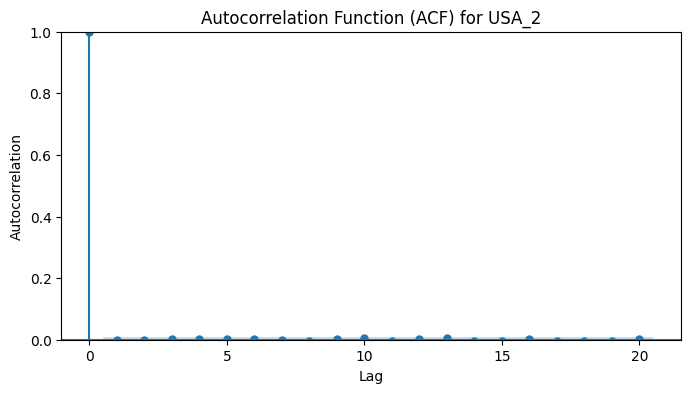

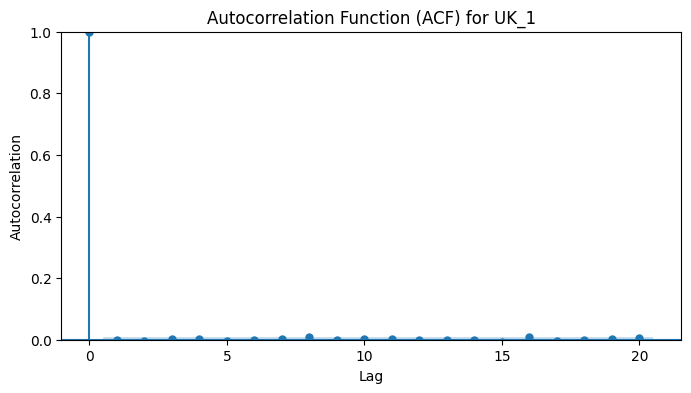

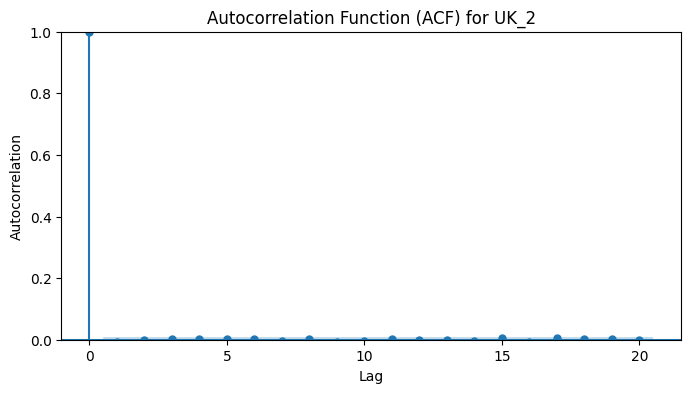

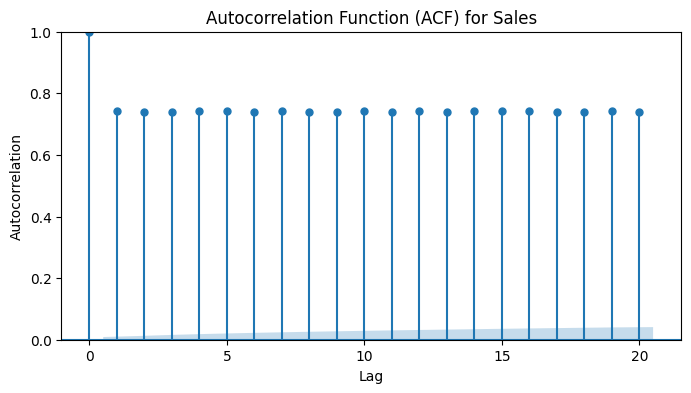

In [ ]:

fig_size = (8, 4)

for column in df.columns:
    fig, ax = plt.subplots(figsize=fig_size)
    plot_acf(df[column], lags=20, ax=ax)

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(0, ymax)

    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(f'Autocorrelation Function (ACF) for {column}')
    plt.show()


It appears that only the sales column exhibits autocorrelation with itself. As a result, I will only include lag features for it, specifically lag 1 and lag 2. Additionally, I plan to introduce a new feature by calculating the rolling average over 7 rows.

In [ ]:
df['Sales_Lag1'] = df['Sales'].shift(1)
df['Sales_Lag2'] = df['Sales'].shift(2)

df['Sales_Rolling_Avg'] = df['Sales'].rolling(window=7).mean()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49942 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AUS_2              49942 non-null  int64  
 1   CAN_2              49942 non-null  int64  
 2   CAN_3              49942 non-null  int64  
 3   GER_1              49942 non-null  int64  
 4   GER_2              49942 non-null  int64  
 5   GER_3              49942 non-null  int64  
 6   FRA_1              49942 non-null  int64  
 7   FRA_2              49942 non-null  int64  
 8   FRA_3              49942 non-null  int64  
 9   IND_1              49942 non-null  int64  
 10  IND_3              49942 non-null  int64  
 11  JAP_1              49942 non-null  int64  
 12  JAP_3              49942 non-null  int64  
 13  USA_1              49942 non-null  int64  
 14  USA_2              49942 non-null  int64  
 15  UK_1               49942 non-null  int64  
 16  UK_2               499

In [ ]:
#deleting rows with NA values due to the creation of new lag features.
df = df.dropna()

df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49936 entries, 0 to 49935
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AUS_2              49936 non-null  int64  
 1   CAN_2              49936 non-null  int64  
 2   CAN_3              49936 non-null  int64  
 3   GER_1              49936 non-null  int64  
 4   GER_2              49936 non-null  int64  
 5   GER_3              49936 non-null  int64  
 6   FRA_1              49936 non-null  int64  
 7   FRA_2              49936 non-null  int64  
 8   FRA_3              49936 non-null  int64  
 9   IND_1              49936 non-null  int64  
 10  IND_3              49936 non-null  int64  
 11  JAP_1              49936 non-null  int64  
 12  JAP_3              49936 non-null  int64  
 13  USA_1              49936 non-null  int64  
 14  USA_2              49936 non-null  int64  
 15  UK_1               49936 non-null  int64  
 16  UK_2               499

Now I scale the demand columns by the values in scaling_df.xlsx

In [ ]:
df.head()

,AUS_2,CAN_2,CAN_3,GER_1,GER_2,GER_3,FRA_1,FRA_2,FRA_3,IND_1,IND_3,JAP_1,JAP_3,USA_1,USA_2,UK_1,UK_2,Sales,Sales_Lag1,Sales_Lag2,Sales_Rolling_Avg
0,1,4,5,2,9,9,6,24,13,14,15,15,19,19,19,23,24,431,383.0,355.0,386.285714
1,2,6,6,5,9,8,26,5,13,13,6,12,17,19,21,21,23,379,431.0,383.0,382.142857
2,4,3,5,6,10,11,1,6,11,13,3,14,19,17,20,21,22,370,379.0,431.0,378.571429
3,3,9,5,8,12,8,14,2,11,13,14,15,18,20,20,23,23,395,370.0,379.0,382.428571
4,0,5,7,2,7,8,26,19,13,12,14,15,16,19,20,22,23,424,395.0,370.0,391.000000


In [ ]:
path = r'/content/drive/My Drive/Data Science Case Study - Senior/scaling_df.xlsx'
df_scale = pd.read_excel(path)
df_scale

,Unnamed: 0,Country,Scaling Factor
0,0,Australia,3.50
1,1,Canada,2.50
2,2,Germany,2.25
3,3,France,1.85
4,4,India,1.20
5,5,Japan,1.55
6,6,United States of America,1.50


In [ ]:

def apply_scaling(column_name, scaling_factor):
    df[column_name] *= scaling_factor

for column in df.columns:
    col_prefix = column[:3]

    matching_country = df_scale[df_scale['Country'].str.contains(col_prefix, case=False)]

    if not matching_country.empty:
        scaling_factor = matching_country['Scaling Factor'].iloc[0]
        apply_scaling(column, scaling_factor)



In [ ]:
df.head()

,AUS_2,CAN_2,CAN_3,GER_1,GER_2,GER_3,FRA_1,FRA_2,FRA_3,IND_1,IND_3,JAP_1,JAP_3,USA_1,USA_2,UK_1,UK_2,Sales,Sales_Lag1,Sales_Lag2,Sales_Rolling_Avg
0,3.5,10.0,12.5,4.50,20.25,20.25,11.10,44.40,24.05,16.8,18.0,23.25,29.45,19,19,23,24,431,383.0,355.0,386.285714
1,7.0,15.0,15.0,11.25,20.25,18.00,48.10,9.25,24.05,15.6,7.2,18.60,26.35,19,21,21,23,379,431.0,383.0,382.142857
2,14.0,7.5,12.5,13.50,22.50,24.75,1.85,11.10,20.35,15.6,3.6,21.70,29.45,17,20,21,22,370,379.0,431.0,378.571429
3,10.5,22.5,12.5,18.00,27.00,18.00,25.90,3.70,20.35,15.6,16.8,23.25,27.90,20,20,23,23,395,370.0,379.0,382.428571
4,0.0,12.5,17.5,4.50,15.75,18.00,48.10,35.15,24.05,14.4,16.8,23.25,24.80,19,20,22,23,424,395.0,370.0,391.000000


## **model building**

I will construct two state-of-the-art models commonly used for time series forecasting: XGBoost and LSTM. While LSTM is touted as a model architecture that slightly outperforms XGBoost in some literature, others have found that XGBoost delivers superior and faster results for time series data. Therefore, as a rule of thumb, it is advisable to experiment with both models and evaluate which architecture yields better predictions.

## Xgboost Model

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

X = df.drop(columns=['Sales'])
y = df['Sales']

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

xgb_model = xgb.XGBRegressor(tree_method='gpu_hist')

param_dist = {
    'n_estimators': range(50, 1000),
    'max_depth': range(1, 20),
    'learning_rate': [0.01,0.02,0.03,0.04, 0.05,0.1,0.2,0.3,0.4,0.5,0.6],
}

random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, n_iter=20,
    scoring='neg_mean_squared_error', cv=tscv, verbose=1, random_state=42, n_jobs=-1
)

train_size = int(0.9 * len(X))
train_index = np.arange(train_size)
test_index = np.arange(train_size, len(X))

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

random_search.fit(X_train, y_train)

best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

train_predictions = best_xgb_model.predict(X)
train_rmse = np.sqrt(mean_squared_error(y, train_predictions))
print("Root Mean Squared Error on Training Data:", train_rmse)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error on Test Data:", rmse)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Root Mean Squared Error on Training Data: 22.008340047593233
Root Mean Squared Error on Test Data: 24.365101330185464


An RMSE of 24 for a dataset with a mean of 500 and a maximum value of 1000 is quite decent. However, to demonstrate the model's effectiveness to business stakeholders, I will utilize two methods. Firstly, I will present a plot illustrating the divergence between predictions and real values. Additionally, I will use the Mean Absolute Percentage Error (MAPE), which is a better business metric than RMSE, to showcase the model's strength. MAPE represents, on average, how far the model's predictions deviate from the true values. A lower MAPE (between 0-10) indicates that, on average, the predictions are quite close to the real values.

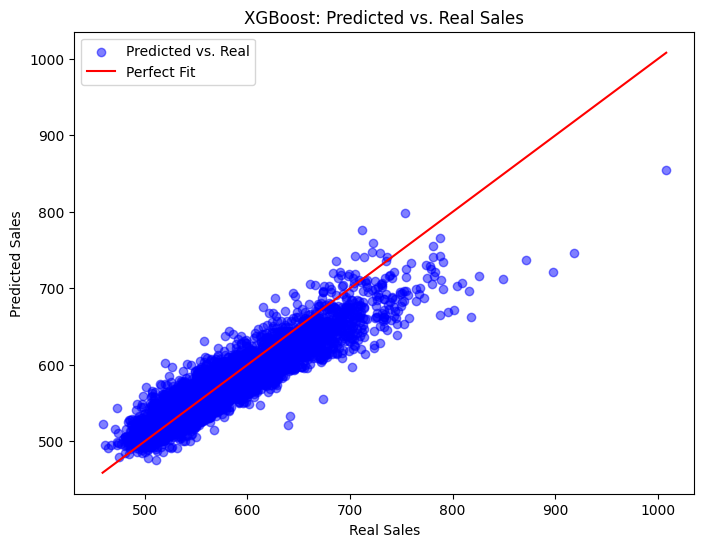

In [ ]:
y_pred = best_xgb_model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='b', label='Predicted vs. Real')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', label='Perfect Fit')
plt.xlabel('Real Sales')
plt.ylabel('Predicted Sales')
plt.title('XGBoost: Predicted vs. Real Sales')
plt.legend()
plt.show()


As we can observe above, the majority of predictions align closely with the perfect fit line for most of the values. However, it is worth noting that for values above 750, there is significant divergence between the predicted values and the actual values. This deviation could possibly be attributed to noise in the data or the presence of outliers. To enhance the model's performance, it might be beneficial to consider removing these outliers from the dataset. Ultimately, the decision to remove outliers should be made by consulting the relevant business department within the company.



The model's outstanding performance becomes even more apparent when we observe the MAPE result shown below: it is an impressive 3%! This means that the model's predictions are only 3% off from the actual values

In [ ]:

mape = (1 / len(y_test)) * np.sum(np.abs((y_test - y_pred) / y_test)) * 100

print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Absolute Percentage Error (MAPE): 3.0474278186465837


LSTM MODEL

In [ ]:

df2=df.copy()
target_column = 'Sales'
y = df2[target_column].values
df2 = df2.drop(columns=[target_column])
X = df2.values

#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)

timesteps = 1
X = X.reshape(X.shape[0], timesteps, X.shape[1])

def root_mean_squared_error(y_true, y_pred):
    y_true = K.cast(y_true, tf.float32)
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

train_split = 0.85
val_split = 0.075
test_split = 0.075

train_idx = int(len(X) * train_split)
val_idx = int(len(X) * (train_split + val_split))

X_train, y_train = X[:train_idx], y[:train_idx]
X_val, y_val = X[train_idx:val_idx], y[train_idx:val_idx]
X_test, y_test = X[val_idx:], y[val_idx:]

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(100))
model.add(Dense(100))

model.add(Dense(1))
model.compile(loss=root_mean_squared_error, optimizer='adam')

batch_size = 32
epochs = 50
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))





Epoch 1/50
1327/1327 [==============================] - 14s 4ms/step - loss: 64.1569 - val_loss: 32.8798
Epoch 2/50
1327/1327 [==============================] - 5s 4ms/step - loss: 30.9545 - val_loss: 31.1891
Epoch 3/50
1327/1327 [==============================] - 5s 4ms/step - loss: 28.7348 - val_loss: 27.1962
Epoch 4/50
1327/1327 [==============================] - 5s 4ms/step - loss: 28.0516 - val_loss: 28.6870
Epoch 5/50
1327/1327 [==============================] - 5s 4ms/step - loss: 27.2732 - val_loss: 30.3049
Epoch 6/50
1327/1327 [==============================] - 5s 4ms/step - loss: 26.7127 - val_loss: 24.5041
Epoch 7/50
1327/1327 [==============================] - 6s 4ms/step - loss: 26.2605 - val_loss: 31.8172
Epoch 8/50
1327/1327 [==============================] - 5s 4ms/step - loss: 25.7605 - val_loss: 27.3900
Epoch 9/50
1327/1327 [==============================] - 5s 4ms/step - loss: 25.5655 - val_loss: 26.8516
Epoch 10/50
1327/1327 [==============================] - 5s 4ms

In [ ]:
loss = model.evaluate(X_test, y_test)
print("Root Mean Squared Error on test set:", loss)


118/118 [==============================] - 0s 2ms/step - loss: 27.3317
Root Mean Squared Error on test set: 27.331724166870117


In [ ]:
predictions = model.predict(X_test)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, predictions)
print("Mean Absolute Percentage Error (MAPE) on test set:", mape)


118/118 [==============================] - 1s 2ms/step
Mean Absolute Percentage Error (MAPE) on test set: 10.328016310704609


LSTM-based artificial neural network implementation resulted in a slightly worse model with an RMSE of 27 and an average percentage error of 10%. This means, on average, it predicted the test set values with 90% accuracy. While it is still a decent model, I would prefer the XGBoost model for predicting the next period's sales, as its mean absolute percentage error is only 3 percent